In [143]:
import pandas as pd
import statsmodels.api as sm
import itertools



class PerformanceReportObject:
    def __init__(self, max_heap_of_performance_reports):
        self.reports = max_heap_of_performance_reports 
    
    def get_top_n_performing_portfolios(n):
        top_n_performing_portfolios = [ heapq.heappop( performance_report ) for i in range(n) ]
        
        for i in range(n):
            heapq.heappush( performance_report, top_n_performing_portfolios[i] )
        
        return [ report[-1] for report in top_n_performing_portfolios ] 
    
    
def generate_performance_reports( portfolios ):
    performance_report = []
    for portfolio in portfolios:
        _stock_list = []
        _beta_sum = 0
        for i in range(len(portfolio)):
            _stock_list.append( portfolio[i][0] )
            _beta_sum += portfolio[i][1]

        _report = get_porfolio_performance( _stock_list, start_date, end_date )
        _report["beta_sum"] = _beta_sum

        heapq.heappush( performance_report, ( -1 * _report["performance"], id(_report), _report )  ) # push to list while maintaining max-heap constraint

    return PerformanceReportObject( performance_report )



    
'''
    Return dictionary with structure: 
    
    {
        stock_list, 
        df_of_performance_of_each_stock_in_stock_list,
        portfolio_performance
    }
    
'''
def get_individual_porfolio_performance( stock_list, start_date, end_date ):
    data_directory = './AlphaData/'
    
    master_df = pd.DataFrame()
    
    for ticker in stock_list:
        stock_df = pd.read_csv( data_directory + ticker + ".csv", parse_dates=True, index_col='date', sep = ',')
        stock_df = apply_daterange_filter( stock_df['close'], start_date, end_date )
        master_df[ ticker ] = stock_df
    
    master_df[ 'portfolio' ] =  master_df.sum( axis=1 )
    
    report = {
        "stock_list": stock_list,
        "data": master_df,
        "performance": ( ( master_df.iloc[0]["portfolio"] - master_df.iloc[-1]["portfolio"] ) / ( master_df.iloc[-1]["portfolio"] ) ) - 1
    }
    
    return report

    
    
def apply_daterange_filter( df, start_date, end_date ):
    _filter = ( df.index.get_level_values(0) >= start_date ) & ( df.index.get_level_values(0) <= end_date )
    return df[ _filter ]

def individual_beta(ind_data, stand_data, start_date, end_date):
    #change to our data
    ind_stock = pd.read_csv(ind_data, parse_dates=True, index_col='date',sep = ',')
    sp_500 = pd.read_csv(stand_data, parse_dates=True, index_col='date', sep = ',') 
    
    ind_stock = apply_daterange_filter( ind_stock, start_date, end_date )
    sp_500 = apply_daterange_filter( sp_500, start_date, end_date )
    
    # joining the closing prices of the two datasets 
    #use recent 1 yrs data for training
    monthly_prices = pd.concat([ind_stock.iloc[0:216,3], sp_500.iloc[0:216,3]], axis=1)
    monthly_prices.columns = ['ind', 'SP500']


    # check the head of the dataframe
    #print(monthly_prices)

    # calculate monthly returns
    monthly_returns = monthly_prices.pct_change(1)
    clean_monthly_returns = monthly_returns.dropna(axis=0)  # drop first missing row

    # split dependent and independent variable
    X = clean_monthly_returns['SP500']
    y = clean_monthly_returns['ind']
    if(len(X) > 0):
        # Add a constant to the independent value
        X1 = sm.add_constant(X)

        # make regression model 
        model = sm.OLS(y, X1)

        # fit model and print results
        results = model.fit()
        #beta of the individual stock
        return results.params[1]
    else:
        return 0
    
'''
compute beta for all individual stocks
'''
def all_beta(s_list, dPath, mPath, start_date, end_date):
    b_list = []
    for stock in s_list:
        stock_path = dPath + str(stock) + '.csv'
        stock_Beta = individual_beta(stock_path, mPath, start_date, end_date)
        if stock_Beta >= -20 and stock_Beta <= 100:
            b_list.append((stock, stock_Beta))
#         else:
#             print(stock, stock_Beta)
    return b_list

'''
generate portfolios
'''
def findPorts(s_list, num, thre):#stock list, size of portfolio, threshold
    port_list = []
    cand_portfolios = set(itertools.combinations(s_list, num))
    for cand_port in cand_portfolios:
        beta_sum = sum(n for _ , n in cand_port)
        if (beta_sum >= thre):
            port_list.append(cand_port)
    return port_list

In [118]:
beta_list = all_beta(stock_list[:100], data_directory, marketPath, start_date, end_date )
portfolios = findPorts( beta_list, 3, 6 )

portfolios

c:\users\tareg\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


ACS 558.691386840729
BHF 5128.468071501958
BSC -384412.95373824297


[(('AZO', 0.4903591145318865),
  ('BIIB', 1.2822383350343982),
  ('BLL', 5.576353955596671)),
 (('A', 1.2231120374482651),
  ('AES', 0.25846209836092604),
  ('BLL', 5.576353955596671)),
 (('ANR', 0), ('ATI', 2.632086734743098), ('BLL', 5.576353955596671)),
 (('AIG', 0.721939301026775),
  ('BIG', 1.1377402554524847),
  ('BLL', 5.576353955596671)),
 (('AXP', 1.1220821171043815),
  ('BEN', 1.351893026535398),
  ('BLL', 5.576353955596671)),
 (('BIIB', 1.2822383350343982),
  ('BLK', 1.3420880719015003),
  ('BLL', 5.576353955596671)),
 (('ADM', 0.7054666483458111),
  ('APH', 1.1081384225830861),
  ('BLL', 5.576353955596671)),
 (('AKAM', 1.4238168453670168),
  ('BHGE', 0.46878571073369846),
  ('BLL', 5.576353955596671)),
 (('ALTR', 3.143764929402493),
  ('AMD', 2.737314292502522),
  ('BBBY', 0.8186765815453059)),
 (('ALTR', 3.143764929402493),
  ('BBBY', 0.8186765815453059),
  ('BLL', 5.576353955596671)),
 (('APA', 1.1007067478508965),
  ('BLL', 5.576353955596671),
  ('BRK.B', 1.0222242424671

In [145]:
len(portfolios)

5573

In [146]:
import heapq

performance_report = []
for portfolio in portfolios:
    _stock_list = []
    _beta_sum = 0
    for i in range(len(portfolio)):
        _stock_list.append( portfolio[i][0] )
        _beta_sum += portfolio[i][1]
        
    _report = get_porfolio_performance( _stock_list, start_date, end_date )
    _report["beta_sum"] = _beta_sum
    
    heapq.heappush( performance_report, ( -1 * _report["performance"], id(_report), _report )  ) # push to list while maintaining max-heap constraint
    


In [156]:
n=20 
top_n_performing_portfolios = [ heapq.heappop( performance_report ) for i in range(n) ]

for i in range(n):
    heapq.heappush( performance_report, top_n_performing_portfolios[i] )


In [157]:
for i in range(len(top_n_performing_portfolios)):
    print( top_n_performing_portfolios[i][2]["performance"] )
#     print( performance_report[i][2]["performance"] )

31.706498951781974
22.17610062893082
16.403916768665855
15.888648648648648
12.635616438356166
12.08590774439272
11.463865096359743
10.812204555221317
8.383557046979865
7.5772577257725775
7.446081504702196
7.288582677165353
7.0918439716312065
7.06189024390244
6.981178337059204
6.666459240821407
6.66045362676847
6.629056718228693
6.320218153486558
6.302082631259688


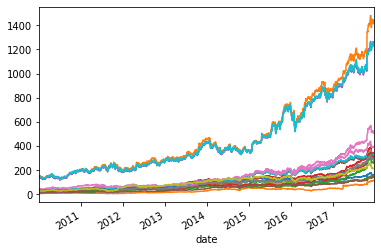

In [163]:
'''
    For each portfolio in the report,
    plot performance vs time
'''
def plot_performance():
    return None


ax = None
for report in top_n_performing_portfolios:
    report = report[2]
    if ( ax == None ):
        ax = report["data"]["portfolio"].plot()
    else:
        report["data"]["portfolio"].plot( ax=ax )

    

In [162]:
ax.

[]

In [105]:
import os, json

cache = None
with open("cache.json") as cache_file:
    cache = json.load( cache_file )

stock_list = cache["stock_list"]

In [106]:
data_directory = './AlphaData/'
sp500_data_file = './AlphaData/SPY.csv' 
i = 0

individual_beta( data_directory + stock_list[i] + ".csv", sp500_data_file)

TypeError: individual_beta() missing 2 required positional arguments: 'start_date' and 'end_date'

In [107]:
sp500_df = pd.read_csv(sp500_data_file, parse_dates=True, index_col='date', sep = ',')

start_date = "2010-01-04"
end_date = "2017-12-29"
  

_filter = ( sp500_df.index.get_level_values(0) >= start_date ) & (sp500_df.index.get_level_values(0) <= end_date )
sp500_df[ _filter ]

,open,high,low,close,volume
date,,,,,
2017-12-29,268.5678,268.550,266.640,266.86,96007400
2017-12-28,267.8900,267.920,267.450,267.87,45116100
2017-12-27,267.3800,267.730,267.010,267.32,57751000
2017-12-26,267.0500,267.438,266.885,267.19,45244400
2017-12-22,267.6000,267.635,266.900,267.51,78720900
...,...,...,...,...,...
2010-01-08,113.8900,114.620,113.660,114.57,126402800
2010-01-07,113.5000,114.330,113.180,114.19,131091100
2010-01-06,113.5215,113.990,113.430,113.71,116074400


In [80]:
master_df = pd.DataFrame()

random_stock_df = pd.read_csv( data_directory + stock_list[i] + ".csv", parse_dates=True, index_col='date', sep = ',')
random_stock_df = apply_daterange_filter( random_stock['close'], start_date, end_date )

master_df[ stock_list[i] ] = random_stock_df

random_stock_df2 = pd.read_csv( data_directory + stock_list[i+1] + ".csv", parse_dates=True, index_col='date', sep = ',')
random_stock_df2 = apply_daterange_filter( random_stock['close'], start_date, end_date )

master_df[ stock_list[i+1] ] = random_stock_df

master_df

,A,AA
date,,
2017-12-29,66.97,66.97
2017-12-28,67.45,67.45
2017-12-27,67.30,67.30
2017-12-26,67.25,67.25
2017-12-22,67.35,67.35
...,...,...
2010-01-08,30.80,30.80
2010-01-07,30.81,30.81
2010-01-06,30.85,30.85


In [82]:
master_df[ 'portfolio' ] =  master_df.sum( axis=1 )

master_df

,A,AA,portfolio
date,,,
2017-12-29,66.97,66.97,133.94
2017-12-28,67.45,67.45,134.90
2017-12-27,67.30,67.30,134.60
2017-12-26,67.25,67.25,134.50
2017-12-22,67.35,67.35,134.70
...,...,...,...
2010-01-08,30.80,30.80,61.60
2010-01-07,30.81,30.81,61.62
2010-01-06,30.85,30.85,61.70


In [86]:
1( master_df.iloc[0]["portfolio"] - master_df.iloc[-1]["portfolio"] ) / ( master_df.iloc[-1]["portfolio"] ) 

1.1396166134185304

In [98]:
get_porfolio_performance( stock_list[:2], start_date, end_date)

{'stock_list': ['A', 'AA'], 'data':                 A     AA  portfolio
 date                               
 2017-12-29  66.97  66.97     133.94
 2017-12-28  67.45  67.45     134.90
 2017-12-27  67.30  67.30     134.60
 2017-12-26  67.25  67.25     134.50
 2017-12-22  67.35  67.35     134.70
 ...           ...    ...        ...
 2010-01-08  30.80  30.80      61.60
 2010-01-07  30.81  30.81      61.62
 2010-01-06  30.85  30.85      61.70
 2010-01-05  30.96  30.96      61.92
 2010-01-04  31.30  31.30      62.60
 
 [2013 rows x 3 columns], 'portfolio_performance': 0.13961661341853038}